In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alpaca.data import TimeFrame

# Import libraries and dependencies
import api_calls

In [2]:
# Call the alpaca api to get the data

# Set the ticker
ticker = "META"

# Set timeframe to '1D'
timeframe = TimeFrame.Day

# Set start and end datetimes, between now and 100 days ago.
start_date = dt.datetime.now() - dt.timedelta(100)
end_date = dt.datetime.now()

# Get 100 days' worth of historical data for SPY
stock_data = api_calls.call_daily(ticker)

stock_data_df = pd.DataFrame(stock_data['Time Series (Daily)']).T

stock_data_df

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2023-03-31,207.24,212.17,206.77,211.94,211.94,25440273,0.0000,1.0
2023-03-30,203.38,208.09,202.82,207.84,207.84,22608303,0.0000,1.0
2023-03-29,203.56,205.72,202.5355,205.35,205.35,18851137,0.0000,1.0
2023-03-28,200.15,201.03,197.9,200.68,200.68,19127295,0.0000,1.0
2023-03-27,204.81,205.86,201.36,202.84,202.84,18527184,0.0000,1.0
...,...,...,...,...,...,...,...,...
2022-11-11,109.23,114.9,108.81,113.02,113.02,59961742,0.0000,1.0
2022-11-10,107.12,112.75,104.61,111.87,111.87,80670961,0.0000,1.0
2022-11-09,101.72,104.9,100.74,101.47,101.47,107677284,0.0000,1.0
2022-11-08,95.92,97.8,94.79,96.47,96.47,52088320,0.0000,1.0


C:\Users\garri\AppData\Local\Temp\ipykernel_9104\3421472934.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks(


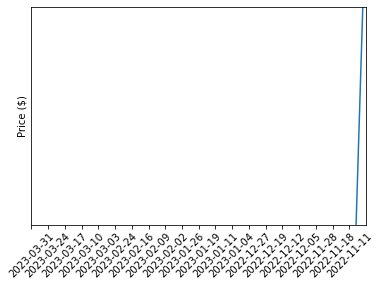

In [3]:
# Plot the adjusted closing prices of the stock
plt.plot(stock_data_df['5. adjusted close'])

# Scale the x-axis to show the full range of dates in ascending order
plt.xlim(0, len(stock_data_df))

# Set the x-tick locations to correspond to just the dates you entered.
plt.xticks(range(0, len(stock_data_df), 5), stock_data_df.index[::5], rotation=45)

# Scale the y-axis to show the full range of prices
plt.ylim(min(stock_data_df['5. adjusted close']), max(stock_data_df['5. adjusted close']))

# Set the y-tick locations to correspond to just the prices you entered.
plt.yticks(
    np.arange(float(min(stock_data_df['5. adjusted close'])), float(max(stock_data_df['5. adjusted close'])), 10.0))

# Set the y-axis label
plt.ylabel("Price ($)")

plt.show()

In [4]:
# Call the alpha vantage api to get the news data

# Set the ticker
ticker = "SCHW"

# Call the news api
news = api_calls.call_news(ticker)

# Convert time to datetime
for i in range(len(news['feed'])):
    news['feed'][i]['time_published'] = dt.datetime.strptime(news['feed'][i]['time_published'], "%Y%m%dT%H%M%S")

# Create a Pandas DataFrame
stock_news = pd.DataFrame(news['feed'])

# Display sample data
stock_news

,title,url,time_published,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
0,Pitney Bowes ( NYSE:PBI ) Stock Rating Lower...,https://www.defenseworld.net/2023/04/01/pitney...,2023-04-01 05:16:42,[Defense World Staff],Pitney Bowes ( NYSE:PBI - Get Rating ) was dow...,https://www.marketbeat.com/logos/pitney-bowes-...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Financial Markets', 'relevance_sco...",0.291819,Somewhat-Bullish,"[{'ticker': 'BLK', 'relevance_score': '0.14646..."
1,The Charles Schwab Corporation ( SCHW ) Stoc...,https://www.zacks.com/stock/news/2073378/the-c...,2023-03-31 22:00:18,[Zacks Investment Research],The Charles Schwab Corporation (SCHW) closed t...,https://staticx-tuner.zacks.com/images/default...,Zacks Commentary,n/a,www.zacks.com,"[{'topic': 'Earnings', 'relevance_score': '0.9...",0.191206,Somewhat-Bullish,"[{'ticker': 'SCHW', 'relevance_score': '0.6957..."
2,TD Announces Dividend Rates on Non-Cumulative ...,https://www.newswire.ca/news-releases/td-annou...,2023-03-31 21:20:00,[TD Bank Group],TD Announces Dividend Rates on Non-Cumulative ...,,Canada Newswire,n/a,www.newswire.ca,"[{'topic': 'Technology', 'relevance_score': '0...",0.377385,Bullish,"[{'ticker': 'TD', 'relevance_score': '0.967314..."
3,QuoteMedia Announces 16% Revenue Growth for 2022,https://www.globenewswire.com/news-release/202...,2023-03-31 19:10:00,"[Inc., QuoteMedia]","PHOENIX, March 31, 2023 ( GLOBE NEWSWIRE ) -- ...",https://ml.globenewswire.com/Resource/Download...,GlobeNewswire,n/a,www.globenewswire.com,"[{'topic': 'Financial Markets', 'relevance_sco...",0.387196,Bullish,"[{'ticker': 'BOM', 'relevance_score': '0.03566..."
4,"Investors 'are pretty afraid right now,' finan...",https://www.cnbc.com/2023/03/31/financial-psyc...,2023-03-31 17:34:49,[Annie Nova],We're in a period of high uncertainty and many...,https://image.cnbcfm.com/api/v1/image/10721798...,CNBC,Top News,www.cnbc.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.024427,Neutral,"[{'ticker': 'SCHW', 'relevance_score': '0.0875..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,H World Group ( NASDAQ:HTHT ) Now Covered by...,https://www.defenseworld.net/2023/03/17/h-worl...,2023-03-17 05:24:45,[Defense World Staff],Analysts at StockNews.com started coverage on ...,https://www.marketbeat.com/logos/h-world-group...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.287845,Somewhat-Bullish,"[{'ticker': 'DKNG', 'relevance_score': '0.0644..."
196,Aethlon Medical ( NASDAQ:AEMD ) Research Cov...,https://www.defenseworld.net/2023/03/17/aethlo...,2023-03-17 05:24:44,[Defense World Staff],Aethlon Medical ( NASDAQ:AEMD ) Research Cover...,https://www.marketbeat.com/logos/aethlon-medic...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Life Sciences', 'relevance_score':...",0.181982,Somewhat-Bullish,"[{'ticker': 'DKNG', 'relevance_score': '0.0925..."
197,Frontline ( NYSE:FRO ) Now Covered by Analys...,https://www.defenseworld.net/2023/03/17/frontl...,2023-03-17 05:24:44,[Defense World Staff],Research analysts at StockNews.com assumed cov...,https://www.americanbankingnews.com/wp-content...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.215066,Somewhat-Bullish,"[{'ticker': 'DKNG', 'relevance_score': '0.0810..."
198,Lindblad Expeditions ( NASDAQ:LIND ) Researc...,https://www.defenseworld.net/2023/03/17/lindbl...,2023-03-17 05:24:44,[Defense World Staff],Lindblad Expeditions ( NASDAQ:LIND ) Research ...,https://www.marketbeat.com/logos/lindblad-expe...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.244567,Somewhat-Bullish,"[{'ticker': 'BLK', 'relevance_score': '0.15851..."


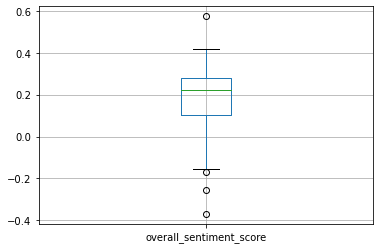

In [5]:
# Create a boxplot of the sentiment analysis of the news
stock_news.boxplot(column=['overall_sentiment_score'])
plt.show()

In [6]:
# Call the alpha vantage api to get the company overview data

# Set the ticker
ticker = "SCHW"

# Call the company overview api
company_overview = api_calls.call_company_overview(ticker)

# Display sample data
pd.DataFrame(company_overview, index=[0])

,Symbol,AssetType,Name,Description,CIK,Exchange,Currency,Country,Sector,Industry,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
0,SCHW,Common Stock,Charles Schwab Corp,The Charles Schwab Corporation is an American ...,316709,NYSE,USD,USA,FINANCE,"SECURITY BROKERS, DEALERS & FLOTATION COMPANIES",...,-,-,0.931,86.36,45,70.9,72.81,1778030000,2023-02-24,2023-02-09


In [7]:
# Call the alpha vantage api to get the income statement data

# Set the ticker
ticker = "SCHW"

# Call the income statement api
income_statement = api_calls.call_income_statement(ticker)

# Display sample data
pd.DataFrame(income_statement['annualReports'])

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
0,2022-12-31,USD,9388000000,20762000000,11374000000,None,4808000000,3214000000,None,3866000000,...,None,652000000,9388000000,2205000000,1545000000,7183000000,-14329000000,10933000000,11585000000,7183000000
1,2021-12-31,USD,7725000000,18520000000,10795000000,None,3175000000,3042000000,None,3674000000,...,None,549000000,7713000000,1858000000,476000000,5855000000,-648000000,8189000000,8738000000,5855000000
2,2020-12-31,USD,4290000000,11691000000,7401000000,None,1030000000,2225000000,None,2815000000,...,None,414000000,4300000000,1001000000,418000000,3299000000,8605000000,4718000000,5132000000,3299000000
3,2019-12-31,USD,4853000000,10721000000,5868000000,1064000000,2422000000,1821000000,None,2170000000,...,322000000,322000000,4848000000,1144000000,1064000000,3704000000,4044000000,5912000000,6234000000,3704000000
4,2018-12-31,USD,4568000000,10132000000,5564000000,857000000,2098000000,1851000000,None,2157000000,...,277000000,277000000,4562000000,1055000000,857000000,3507000000,3440000000,5419000000,5696000000,3507000000


In [8]:
# Call the alpha vantage api to get the balance sheet data

# Set the ticker
ticker = "SCHW"

# Call the balance sheet api
balance_sheet = api_calls.call_balance_sheet(ticker)

# Display sample data
pd.DataFrame(balance_sheet['annualReports'])

,fiscalDateEnding,reportedCurrency,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,...,currentLongTermDebt,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStock,commonStockSharesOutstanding
0,2022-12-31,USD,551772000000,40195000000,40195000000,40195000000,None,None,21700000000,3648000000,...,17050000000,20760000000,58671000000,366724000000,None,36608000000,8639000000,31066000000,21000000,1864000000
1,2021-12-31,USD,667270000000,62975000000,62975000000,62975000000,None,None,22266000000,3442000000,...,4855000000,18820000000,23769000000,443778000000,None,56261000000,5338000000,25992000000,21000000,1893000000
2,2020-12-31,USD,549009000000,40348000000,40348000000,40348000000,None,None,25763000000,2883000000,...,None,13626000000,13632000000,358022000000,None,56060000000,5578000000,21975000000,20000000,1848000000
3,2019-12-31,USD,294000000000,29345000000,29345000000,29345000000,None,None,4060000000,2128000000,...,None,7430000000,7430000000,225610000000,None,21745000000,5767000000,19960000000,15000000,1284000000
4,2018-12-31,USD,296482000000,27938000000,27938000000,27938000000,None,None,3147000000,1769000000,...,None,6878000000,13759000000,234429000000,None,20670000000,3714000000,17329000000,15000000,1343000000


In [10]:
# Call the alpha vantage api to get the cash flow data

# Set the ticker
ticker = "SCHW"

# Call the cash flow api
cash_flow = api_calls.call_cash_flow(ticker)

# Display sample data
pd.DataFrame(cash_flow['annualReports'])

,fiscalDateEnding,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome
0,2022-12-31,USD,2057000000,3727000000,None,-31759000000,-99000000,1971000000,952000000,None,...,2110000000,None,None,2971000000,740000000,-3591000000,None,-34618000000,None,7183000000
1,2021-12-31,USD,2118000000,2924000000,None,22792000000,1152000000,2961000000,1041000000,None,...,1822000000,None,None,7036000000,2806000000,2427000000,None,22778000000,None,5855000000
2,2020-12-31,USD,6852000000,1489000000,None,25761000000,-4000000,1776000000,741000000,None,...,1280000000,None,None,3070000000,4940000000,5019000000,None,24983000000,None,3299000000
3,2019-12-31,USD,9325000000,2407000000,None,6253000000,709000000,795000000,753000000,None,...,1060000000,None,None,593000000,0,-2102000000,None,7350000000,None,3704000000
4,2018-12-31,USD,12456000000,1725000000,None,2096000000,8000000,656000000,576000000,-96000000,...,787000000,None,None,3024000000,0,-875000000,None,19067000000,None,3507000000


In [11]:
# Call the alpha vantage api to get the earnings data

# Set the ticker
ticker = "SCHW"

# Call the earnings api
earnings = api_calls.call_earnings(ticker)

# Display sample data
pd.DataFrame(earnings['quarterlyEarnings'])

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2022-12-31,2023-01-18,1.09,1.09,0,0
1,2022-09-30,2022-10-17,1.1,1.05,0.05,4.7619
2,2022-06-30,2022-07-18,0.97,0.91,0.06,6.5934
3,2022-03-31,2022-04-18,0.77,0.84,-0.07,-8.3333
4,2021-12-31,2022-01-18,0.86,0.88,-0.02,-2.2727
...,...,...,...,...,...,...
103,1997-03-31,1997-04-16,0.05,0.05,0,0
104,1996-12-31,1997-01-16,0.05,0.05,0,0
105,1996-09-30,1996-10-11,0.05,0.04,0.01,25
106,1996-06-30,1996-07-17,0.06,0.04,0.02,50


In [12]:
# Combine the income statement, balance sheet, and cash flow data into a single DataFrame

# Create a list of the dataframes
dataframes = [pd.DataFrame(income_statement['annualReports']), pd.DataFrame(balance_sheet['annualReports']), pd.DataFrame(cash_flow['annualReports'])]

# Concatenate the dataframes
combined_df = pd.concat(dataframes, axis=1)

# Display sample data
combined_df

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome
0,2022-12-31,USD,9388000000,20762000000,11374000000,None,4808000000,3214000000,None,3866000000,...,2110000000,None,None,2971000000,740000000,-3591000000,None,-34618000000,None,7183000000
1,2021-12-31,USD,7725000000,18520000000,10795000000,None,3175000000,3042000000,None,3674000000,...,1822000000,None,None,7036000000,2806000000,2427000000,None,22778000000,None,5855000000
2,2020-12-31,USD,4290000000,11691000000,7401000000,None,1030000000,2225000000,None,2815000000,...,1280000000,None,None,3070000000,4940000000,5019000000,None,24983000000,None,3299000000
3,2019-12-31,USD,4853000000,10721000000,5868000000,1064000000,2422000000,1821000000,None,2170000000,...,1060000000,None,None,593000000,0,-2102000000,None,7350000000,None,3704000000
4,2018-12-31,USD,4568000000,10132000000,5564000000,857000000,2098000000,1851000000,None,2157000000,...,787000000,None,None,3024000000,0,-875000000,None,19067000000,None,3507000000
